In [1]:
!pip install contractions
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import indian
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata
from keras.models import Sequential,Model
from keras.layers import Input,Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from deep_translator import GoogleTranslator
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
import spacy
import contractions
from nltk.corpus import stopwords
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Reading the Data

In [4]:

data = pd.read_csv('/content/drive/MyDrive/fichier_sans_lignes_vides.csv')

# French-Ling Sample Data

In [5]:
data.sample(5)

,Français,Lingala
3200,Telle est la loi concernant celui qui est atte...,Oyo nde mibeko mpo na mobali oyo azali kobima ...
7661,"Alors le Philistin regarda, et vit David, et l...",Tango moto ya Filisitia atalaki mpe amonaki Da...
29442,"Quelques-uns, il est vrai, prêchent Christ par...",Ezali solo ete bamoko bazali kosakola Klisto m...
26258,Jésus leur dit: Ma nourriture est de faire la ...,Yesu alobaki na bango : — Bilei na Ngai ezali ...
29337,"Or, à Celui qui peut faire, par la puissance q...",Epai na Ye oyo azali na makoki ya kosala kolek...


# Data Preprocessing
* Null Value Checking and Removing

In [6]:
data.isnull().sum()

,0
Français,72
Lingala,0


In [7]:
data.dropna(inplace = True )

* LOWERCASING

In [8]:
data['Français'] = data['Français'].str.lower()
data['Lingala'] = data['Lingala'].str.lower()

* Removing HTML Tags

In [9]:
def remove_html(text):
    if isinstance(text,str):

        pattern = re.compile('<.*?>')
        return pattern.sub(r'',text)
    else:
        return text

data['Français'] = data['Français'].apply(remove_html)
data['Lingala'] = data['Lingala'].apply(remove_html)

* Removing URL's

In [10]:
def remove_url(text):
    if isinstance(text,str):
        pattern = re.compile(r'https?://\S+|www\.\S+')
        return pattern.sub(r'',text)
    else:
        return
data['Français'] = data['Français'].apply(remove_url)
data['Lingala'] = data['Lingala'].apply(remove_url)

* Remove NonAlphanumeric characters

In [11]:
def preprocess_text(text, language='french'):
    if not isinstance(text, str):
        return text

    if language == 'french':
        pattern = r'[^a-zA-Z0-9\s]'
    elif language == 'lingala':
        pattern = r'[^\u0900-\u097F\s]'
    else:
        raise ValueError("Unsupported Language, Supported languages are 'french' and 'lingala'")

    return pd.Series(text).str.replace(pattern, '', regex=True).tolist()

data['Français'] = preprocess_text(data['Français'], language='french')
data['Lingala'] = preprocess_text(data['Lingala'], language='lingala')

* Removing Punctuations

In [12]:
#Punctuations...........
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
def get_lingala_punctuations():
    lingala_punctuations = []
    for i in range(0x2000, 0x206f + 1):
        char = chr(i)
        if unicodedata.category(char) == 'Po':
            lingala_punctuations.append(char)
    return ''.join(lingala_punctuations)

# Get Lingala punctuation characters
lingala_punctuation = get_lingala_punctuations()

# Print Lingala punctuation characters
print('Lingala Punctuation: ', lingala_punctuation)

Lingala Punctuation:  ‖‗†‡•‣․‥…‧‰‱′″‴‵‶‷‸※‼‽‾⁁⁂⁃⁇⁈⁉⁊⁋⁌⁍⁎⁏⁐⁑⁓⁕⁖⁗⁘⁙⁚⁛⁜⁝⁞


In [14]:
import string

def remove_punctuation(text, language = 'French'):
    if language == 'French':
        exclude = set(string.punctuation)
        return ''.join(char for char in text if char not in exclude)
    elif language == 'Lingala':
        # Define the set of Lingala punctuation characters here
        lingala_punctuation = set([...])
        return ''.join(char for char in text if char not in lingala_punctuation)
    else:
        raise ValueError("Unsupported Language, Supported languages are 'French' and 'Lingala'")

data['Français'] = data['Français'].apply(lambda x: remove_punctuation(x, language='French'))
data['Lingala'] = data['Lingala'].apply(lambda x: remove_punctuation(x, language='Lingala'))


* Removing contractions

In [15]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

data['Français'] = data['Français'].apply(expand_contractions)

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

* Tokenize the text

In [17]:
def do_tokenization(text):
    token_words = word_tokenize(text)
    return token_words

data['Français'] = data['Français'].apply(do_tokenization)
data['Lingala'] = data['Lingala'].apply(do_tokenization)

In [18]:
data.sample(5)

,Français,Lingala
24194,"[et, il, le, nia, encore, avec, serment, en, d...","[petelo, awanganaki, yango, lisusu, na, kolapa..."
3344,"[vous, serez, saints, pour, moi, car, je, suis...","[bozala, bule, ,, bato, oyo, babulisami, mpo, ..."
9544,"[et, ils, lui, dirent, cest, un, homme, vêtu, ...","[bazongisaki, :, —, azalaki, mobali, moko, ala..."
18290,"[que, ses, princes, soient, à, tsoan, et, que,...","[ata, bakalaka, na, bango, bazali, na, tsoani,..."
15277,"[chantez, avec, allégresse, à, dieu, notre, fo...","[boganga, na, esengo, epai, ya, nzambe, ,, mak..."


* Removing Stop Words

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
stop_words_french = set(stopwords.words('french'))

In [21]:
import nltk.corpus
stop_words_ling = set(stopwords.words('french'))

In [22]:
def remove_stopwords(text,language = 'french'):
    if language == 'french':
        filtered_words_english = [word for word in text if word.lower() not in stop_words_french]
        return ' '.join(filtered_words_english)
    elif language == 'lingala':
        filterd_words_hindi = [word for word in text if word not in stop_words_ling]
        return ' '.join(filterd_words_hindi)
    else:
        return ValueError("Unsupported Language, Supported languages are 'english' and 'Lingala'")

data['Français'] = data['Français'].apply(lambda x :remove_stopwords(x,language = 'french'))
data['Lingala'] = data['Lingala'].apply(lambda x :remove_stopwords(x,language = 'lingala'))

In [23]:
data.sample(5)

,Français,Lingala
22871,jour trompettes dalarmes contre villes fortes ...,mokolo ya kobeta bakelelo mpe ya makelele ya b...
11938,josias âgé huit ans quand devint roi régna tre...,joziasi azalaki na mibu mwambe ya mbotama tang...
5354,réjouiras devant léternel dieu fils fille serv...,"okosepela liboso ya yawe , nzambe na yo , na e..."
23742,répondit quand soir venu dites fera beau temps...,"yesu azongiselaki bango : — na pokwa , bolobak..."
29456,parce quil a fait grâce because christ non seu...,"mpo na oyo etali klisto , nzambe apesaki bino ..."


In [24]:
def do_stemming(token_words):
    ps = PorterStemmer()
    words = token_words.split()
    return [ps.stem(word) for word in words]

data['Français'] = data['Français'].apply(do_stemming)
data['Lingala'] = data['Lingala'].apply(do_stemming)

In [25]:
data.sample(5)

,Français,Lingala
30791,"[celui, a, oreil, écout, lesprit, dit, église,...","[tika, ete, moto, oyo, azali, na, matoyi, mpo,..."
8308,"[alor, david, leva, terr, lava, soignit, chang...","[bongo, davidi, atelemaki, wuta, na, mabel, ,,..."
26670,"[philipp, vint, dit, andré, andré, philipp, di...","[filipo, akendeki, koyebisa, andr, ;, bongo, b..."
7212,"[salmon, père, booz, booz, père, dobe]","[salima, abotaki, boazi, ,, boazi, abotaki, ob..."
4951,"[horien, demeurai, aussi, auparav, séir, desce...","[bato, ya, ori, mpe, bazalaki, kovanda, na, se..."


# Word Cloud

In [26]:
# Function to preprocess text and generate word cloud
def generate_wordcloud(text_list, language):
    # Join the list of words into a single string
    text_str = ' '.join(map(str, text_list))

    # Generate word cloud without specifying font path
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_str)

    # Display word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {language} Text")
    plt.axis('off')
    plt.show()

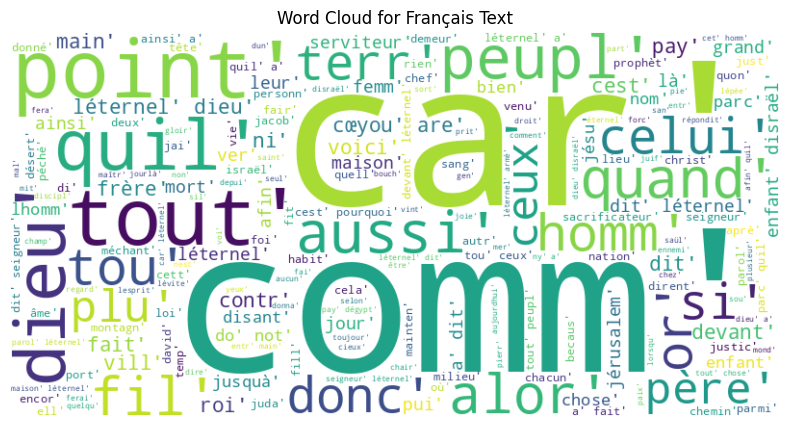

In [27]:
# Generate word clouds for French columns
generate_wordcloud(data['Français'], 'Français')

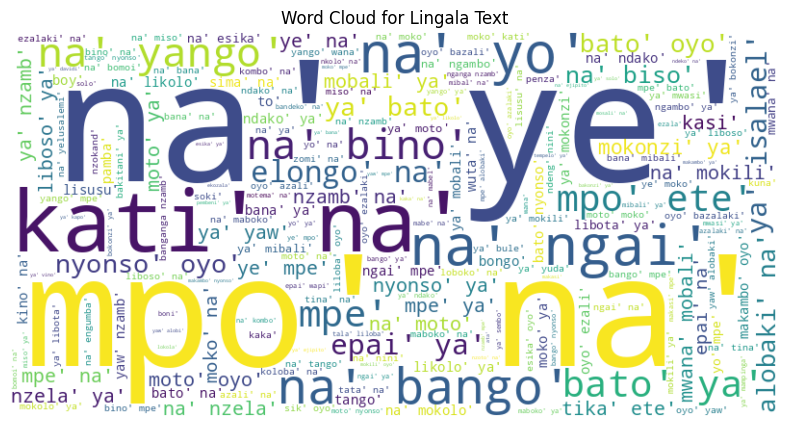

In [28]:
# Generate word clouds for Lingala columns
generate_wordcloud(data['Lingala'], 'Lingala')

In [29]:
def calculate_max_sequence_length(text):
    # Concatenate x_train_seq and x_test_seq
    combined_sequences = text
    max_length_combined = max(len(sequence) for sequence in combined_sequences)

    return max_length_combined

max_length_combined_x = calculate_max_sequence_length(data['Français'])
print("Maximum sequence length in combined dataset x: ", max_length_combined_x)
max_length_combined_y = calculate_max_sequence_length(data['Lingala'])
print("Maximum sequence length in combined dataset x: ", max_length_combined_y)

Maximum sequence length in combined dataset x:  43
Maximum sequence length in combined dataset x:  104


# Tokenization on text data

In [30]:
tok = Tokenizer()
tok.fit_on_texts(data['Français'])

In [31]:
tok_lingala = Tokenizer()
tok_lingala.fit_on_texts(data['Lingala'])

In [32]:
# Add special tokens to the Lingala tokenizer
tok_lingala.word_index['<start>'] = len(tok_lingala.word_index) + 1
tok_lingala.word_index['<end>'] = len(tok_lingala.word_index) + 1

In [33]:
len(tok.word_index), len(tok_lingala.word_index)

(20207, 14287)

In [34]:
def add_special_tokens(sequences, start_token='<start>', end_token='<end>'):
    sequences_with_special_tokens = []
    for sequence in sequences:
        sequence_with_special_tokens = [start_token] + sequence + [end_token]
        sequences_with_special_tokens.append(sequence_with_special_tokens)
    return sequences_with_special_tokens

data['Lingala'] = add_special_tokens(data['Lingala'])

# Converting words to the number

In [35]:
#Now we are goining to convert text to sequences.......
data['Français'] = tok.texts_to_sequences(data['Français'])
data['Lingala'] = tok_lingala.texts_to_sequences(data['Lingala'])

In [36]:
def calculate_max_sequence_length(text):
    # Concatenate x_train_seq and x_test_seq
    combined_sequences = text
    max_length_combined = max(len(sequence) for sequence in combined_sequences)

    return max_length_combined

max_length_combined_x = calculate_max_sequence_length(data['Français'])
print("Maximum sequence length in combined dataset x: ", max_length_combined_x)
max_length_combined_y = calculate_max_sequence_length(data['Lingala'])
print("Maximum sequence length in combined dataset x: ", max_length_combined_y)

Maximum sequence length in combined dataset x:  43
Maximum sequence length in combined dataset x:  106


In [37]:
data.sample(5)

,Français,Lingala
5663,"[499, 241, 431, 241, 1064, 65, 1554, 1551, 202...","[14286, 1210, 42, 2, 236, 1, 22, 5, 183, 2, 87..."
22054,"[7577, 99, 5053, 1888, 26, 9287, 69, 54, 9217,...","[14286, 1, 229, 54, 1, 7, 3, 1534, 1100, 12, 9..."
20508,"[33, 590, 3762, 3307, 1, 5, 210, 18, 703, 7012...","[14286, 1737, 1, 19, 3, 6, 12792, 106, 3612, 1..."
28473,"[1160, 556, 216, 238, 216, 266, 4, 425, 46, 10...","[14286, 120, 38, 3, 2206, 145, 2, 47, 3, 26, 2..."
5353,"[62, 4368, 502, 1596, 1731, 1, 4, 7180, 26, 75...","[14286, 578, 322, 2, 1529, 8, 1, 19, 3, 23, 1,..."


# Train Test Split

In [38]:
french = data['Français']
lingala = data['Lingala']

In [39]:
x_train,x_test,y_train,y_test = train_test_split(french,lingala,test_size = 0.2, random_state = 42)

In [40]:
print("Training set shape: ",x_train.shape,y_train.shape)
print("Testing set shape: ",x_test.shape,y_test.shape)

Training set shape:  (24878,) (24878,)
Testing set shape:  (6220,) (6220,)


# Sample Representation Of Words How Words Get Converted Into Numbers

In [41]:
for num in x_train[24877]:
    print(num,end = " ")

44 467 58 3 2553 1782 275 28 59 60 263 239 1997 6 

In [42]:
#Corresponding words .........
for num in x_train[24877]:
    word = tok.index_word.get(num)
    print(word,end = " ")

or principaux sacrificateur tout sanhédrin cherchaient témoignag contr jésu fair mourir nen trouvaient point 

In [43]:
#Corresponding words .........
for num in y_train[24877]:
    word = tok_lingala.index_word.get(num)
    print(word,end = " ")

None nzokand bakonzi ya banganga-nzamb mpe bato nyonso ya likita-monen ya bayuda bazalaki koluka litatoli moko oyo ekobimisa polel mabe ya yesu mpo ete bakoka kokatela ye etumbu ya kufa , kasi bazalaki kozwa yango ; None 

# Padding of the data

In [44]:
x_train_main = pad_sequences(x_train, maxlen=max_length_combined_x, padding='post')
y_train_main = pad_sequences(y_train, maxlen=max_length_combined_y, padding='post')

In [45]:
x_test_main = pad_sequences(x_test, maxlen=max_length_combined_x, padding='post')
y_test_main = pad_sequences(y_test, maxlen=max_length_combined_y, padding='post')

In [46]:
print("shape of x_train_main is :",x_train_main.shape)
print("shape of y_train_main is :",y_train_main.shape)
print("shape of x_test_main is :",x_test_main.shape)
print("shape of y_test_main is :",y_test_main.shape)

shape of x_train_main is : (24878, 43)
shape of y_train_main is : (24878, 106)
shape of x_test_main is : (6220, 43)
shape of y_test_main is : (6220, 106)


In [47]:
x_train_main

array([[ 839,   80,  637, ...,    0,    0,    0],
       [   7,   29, 2477, ...,    0,    0,    0],
       [ 463,  133,   19, ...,    0,    0,    0],
       ...,
       [   7,  298,  342, ...,    0,    0,    0],
       [ 230,  619,   22, ...,    0,    0,    0],
       [ 172, 1094,   79, ...,    0,    0,    0]], dtype=int32)

In [48]:
x_train_main

array([[ 839,   80,  637, ...,    0,    0,    0],
       [   7,   29, 2477, ...,    0,    0,    0],
       [ 463,  133,   19, ...,    0,    0,    0],
       ...,
       [   7,  298,  342, ...,    0,    0,    0],
       [ 230,  619,   22, ...,    0,    0,    0],
       [ 172, 1094,   79, ...,    0,    0,    0]], dtype=int32)

# Creating model

In [49]:
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.models import Model

In [50]:
def create_model(vocab_size_input, vocab_size_output, max_seq_length_input, max_seq_length_output, embedding_dim, num_heads, num_transformer_layers):
  # Encoder input layer
  encoder_inputs = Input(shape=(max_seq_length_input,))
  # Encoder embedding layer
  encoder_embedding = Embedding(input_dim=vocab_size_input, output_dim=embedding_dim)(encoder_inputs)
  # Encoder Transformer layers
  encoder_output = encoder_embedding
  for _ in range(num_transformer_layers):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(encoder_output, encoder_output)
    attn_output = LayerNormalization()(encoder_output + attn_output)
    attn_output = Dropout(0.1)(attn_output)
    encoder_output = Dense(embedding_dim, activation='relu')(attn_output)
    encoder_output = LayerNormalization()(encoder_output)

  # Decoder input layer
  decoder_inputs = Input(shape=(max_seq_length_output,))
  # Decoder embedding layer
  decoder_embedding = Embedding(input_dim=vocab_size_output, output_dim=embedding_dim)(decoder_inputs)

  # Decoder Transformer layers
  decoder_output = decoder_embedding
  for _ in range(num_transformer_layers):
    attn_output1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(decoder_output, decoder_output)
    attn_output1 = LayerNormalization()(decoder_output + attn_output1)
    attn_output1 = Dropout(0.1)(attn_output1)
    attn_output2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(attn_output1, encoder_output)
    attn_output2 = LayerNormalization()(attn_output1 + attn_output2)
    attn_output2 = Dropout(0.1)(attn_output2)
    decoder_output = Dense(embedding_dim, activation='relu')(attn_output2)
    decoder_output = LayerNormalization()(decoder_output)

  # Decoder output layer
  decoder_outputs = Dense(vocab_size_output, activation='softmax')(decoder_output)

  # Define the model
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  # print(model.summary())
  return model

In [51]:
vocab_size_input = len(tok.word_index) + 1  # Add 1 for padding token
vocab_size_output = len(tok_lingala.word_index) + 1  # Add 1 for padding token

print("Vocabulary size for French:", vocab_size_input)
print("Vocabulary size for Lingala:", vocab_size_output)

Vocabulary size for French: 20208
Vocabulary size for Lingala: 14288


In [52]:
def calculate_max_sequence_length(text):
    # Concatenate x_train_seq and x_test_seq
    combined_sequences = text
    max_length_combined = max(len(sequence) for sequence in combined_sequences)

    return max_length_combined

max_seq_length_input = calculate_max_sequence_length(data['Français'])
print("Maximum sequence length in combined french dataset: ", max_seq_length_input)
max_seq_length_output = calculate_max_sequence_length(data['Lingala']) - 1
print("Maximum sequence length in combined lingala dataset: ", max_seq_length_output)

Maximum sequence length in combined french dataset:  43
Maximum sequence length in combined lingala dataset:  105


In [84]:
embedding_dim = 100
# hidden_units = 256
batch_size = 128
# nombre de têtes d'attention
num_heads = 3
# nombre de couches de transformer
num_transformer_layers = 2

model = create_model(vocab_size_input, vocab_size_output, max_seq_length_input, max_seq_length_output, embedding_dim, num_heads, num_transformer_layers)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [54]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 43)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 43, 100)        │      2,020,800 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 43, 100)        │         39,997 │ embedding[0][0],       │
│ (MultiHeadAttention)      │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 43, 100)        │              0 │ embedding[0][0],       │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 43, 100)        │            200 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 43, 100)        │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 43, 100)        │         10,100 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 43, 100)        │            200 │ dense[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 105)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 43, 100)        │         39,997 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 105, 100)       │      1,428,800 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 43, 100)        │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 105, 100)       │         39,997 │ embedding_1[0][0],     │
│ (MultiHeadAttention)      │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 43, 100)        │            200 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 105, 100)       │              0 │ embedding_1[0][0],     │
│                      

 Total params: 5,175,070 (19.74 MB)

 Trainable params: 5,175,070 (19.74 MB)

 Non-trainable params: 0 (0.00 B)

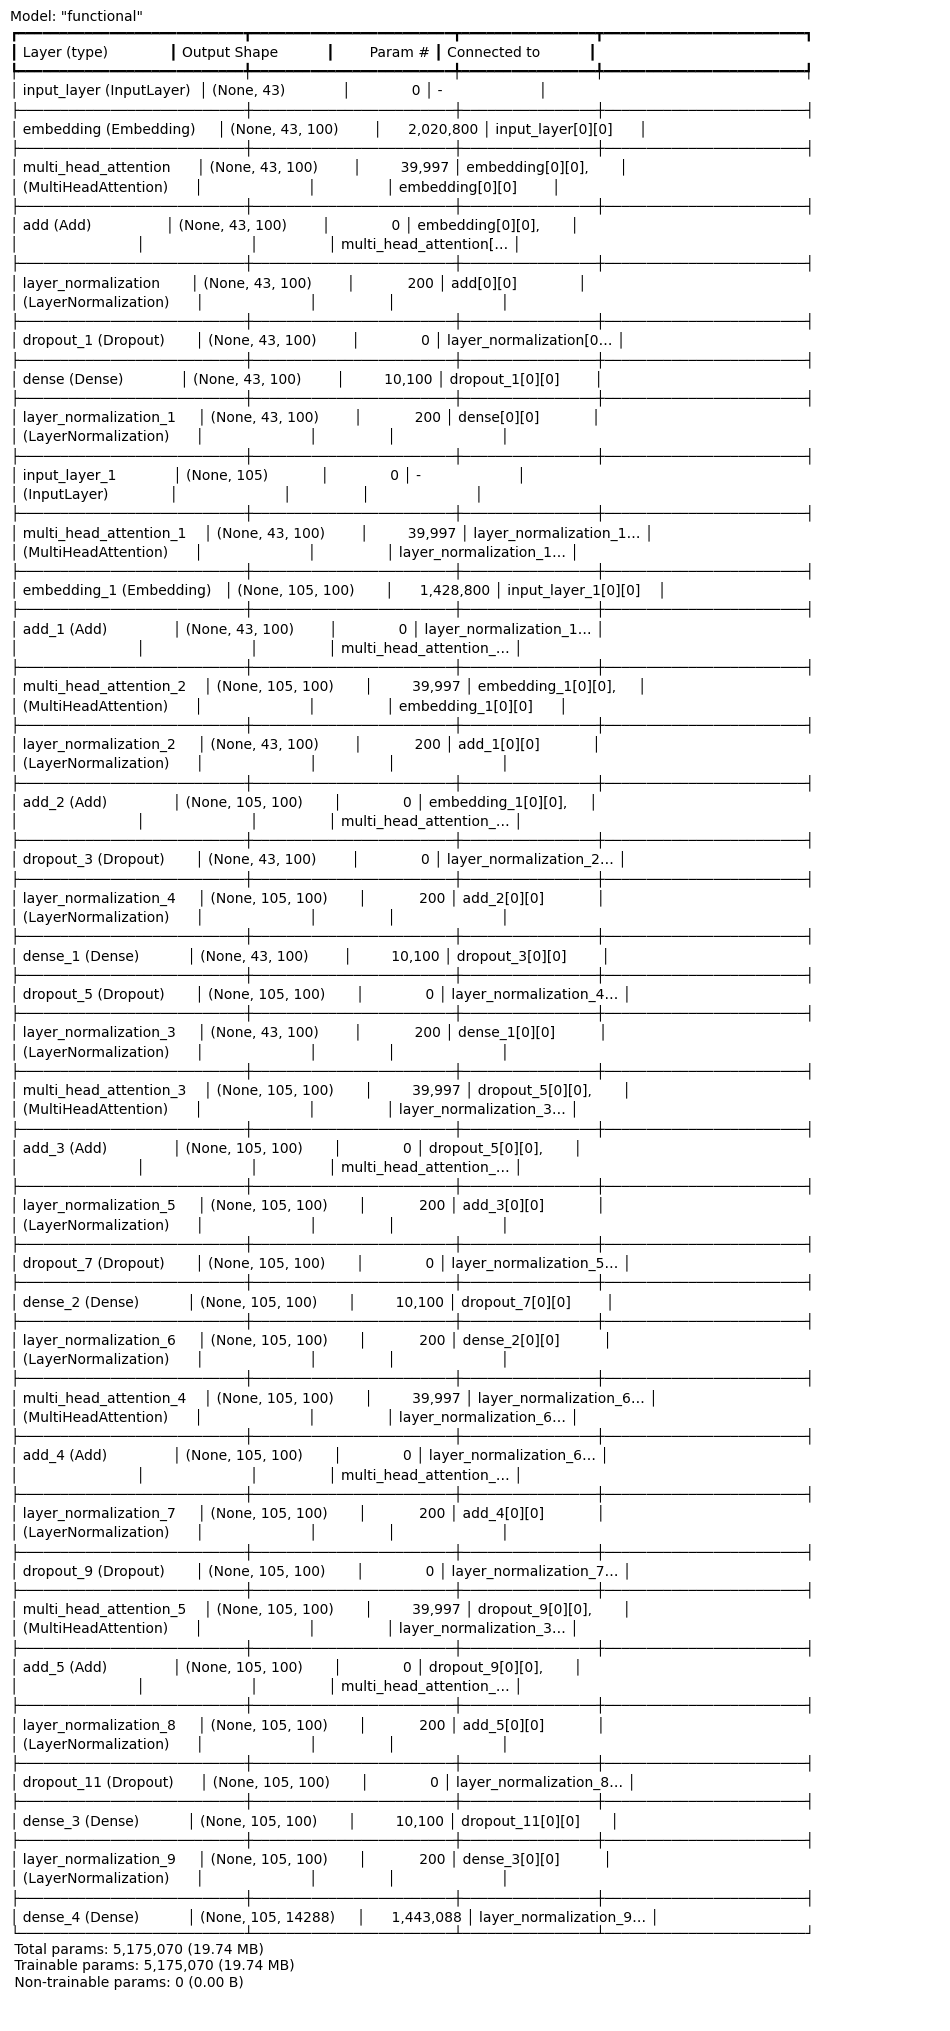

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

# Capturer la sortie du résumé du modèle
buffer = BytesIO()
model.summary(print_fn=lambda x: buffer.write(x.encode() + b"\n"))
summary_text = buffer.getvalue().decode()

# Créer une image à partir du texte
fig = plt.figure(figsize=(12, 8))
plt.axis('off')
plt.text(0, 0, summary_text, fontsize=10, verticalalignment='center')
plt.savefig('model_summary.png', bbox_inches='tight')
plt.show()

In [61]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),  # Stop training if validation loss stops improving for 3 epochs
    ModelCheckpoint(filepath='model_weights.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss')  # Save the model with the best validation loss
]

# Fit the model with callbacks
history = model.fit(x=[x_train_main, y_train_main[:, :-1]],  # Exclude last token from decoder input
                    y=y_train_main[:, 1:],  # Exclude first token from decoder target
                    batch_size=batch_size,
                    epochs=20,
                    validation_data=([x_test_main, y_test_main[:, :-1]], y_test_main[:, 1:]),
                    callbacks=callbacks)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 239ms/step - accuracy: 0.6951 - loss: 4.5433 - val_accuracy: 0.7776 - val_loss: 1.3821
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - accuracy: 0.7812 - loss: 1.3367 - val_accuracy: 0.7895 - val_loss: 1.2525
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.7929 - loss: 1.2271 - val_accuracy: 0.8023 - val_loss: 1.1658
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.8056 - loss: 1.1334 - val_accuracy: 0.8117 - val_loss: 1.0897
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.8138 - loss: 1.0553 - val_accuracy: 0.8162 - val_loss: 1.0319
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.8188 - loss: 0.9937 - val_accuracy: 0.8205 - val_loss: 0.9864
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.8240 - loss: 0.9329 - val_accuracy: 0.8233 - val_loss: 0.9510
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.8277 - loss: 0

In [62]:
weights_file_path = '/content/model_weights.weights.h5'

model.save_weights(weights_file_path)

print("Model weights saved successfully.")

Model weights saved successfully.


# Model Training Graph

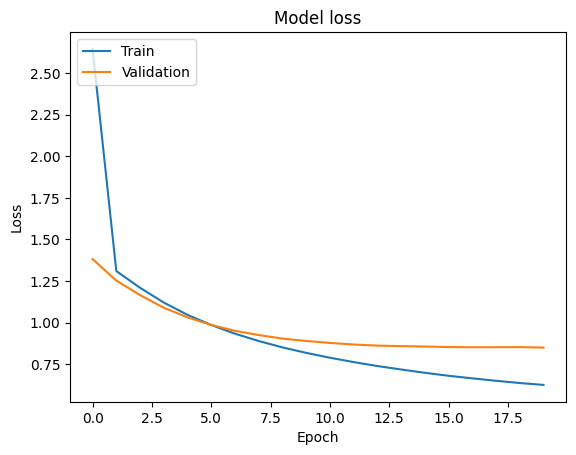

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

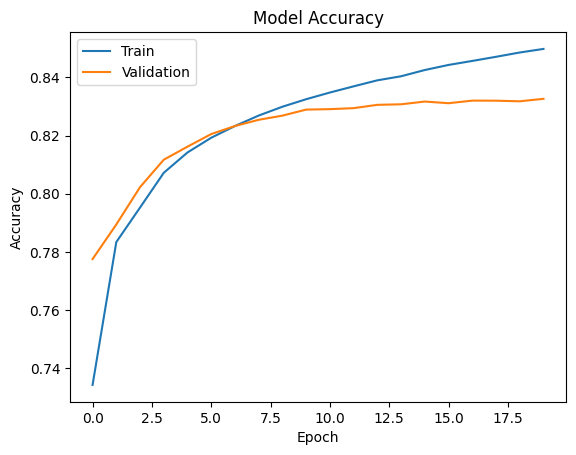

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

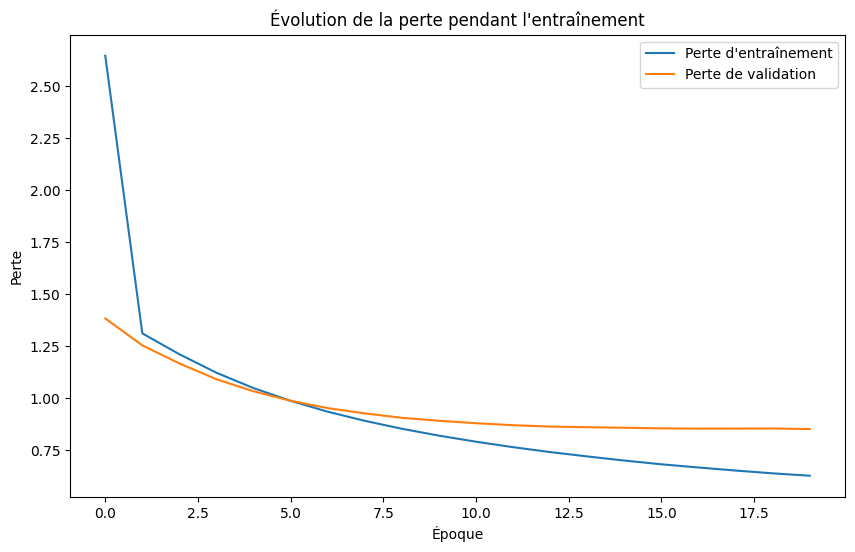

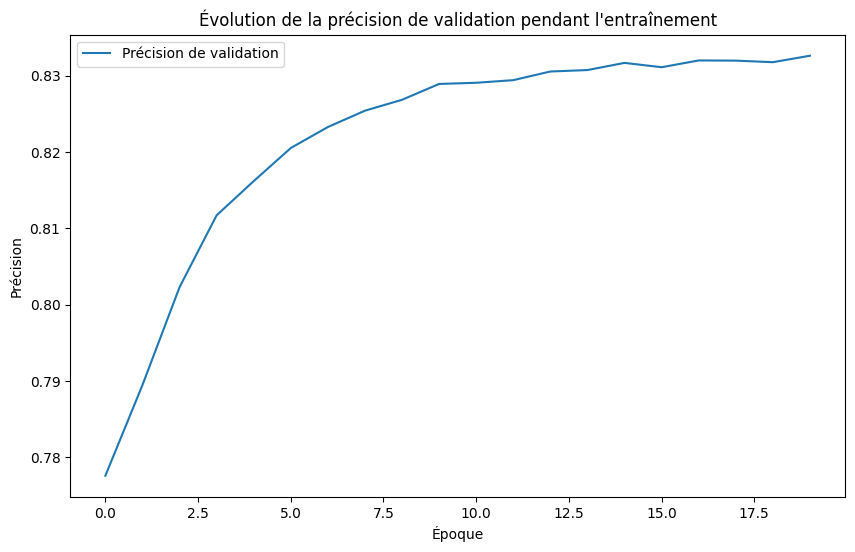

In [65]:
import matplotlib.pyplot as plt

# Tracer les courbes d'évolution de la perte et de la métrique de validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.savefig('history_loss.png')
plt.show()

# Tracer les courbes d'évolution de la métrique de validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Précision de validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.title('Évolution de la précision de validation pendant l\'entraînement')
plt.legend()
plt.savefig('history_accuracy.png')
plt.show()

# Predictions

In [96]:
model = create_model(vocab_size_input, vocab_size_output, max_seq_length_input, max_seq_length_output, embedding_dim, num_heads, num_transformer_layers)
# Load the saved weights into the model
model.load_weights('/content/model_weights.weights.h5')

In [97]:
x_test_main.shape

(6220, 43)

In [98]:
x_test_main[1]

array([   36,  1494,     9,  4066,  2370,  6482,  2276,    28,  1037,
       14445,    19,   730,  7377,  3373,   762,   716,    38,   316,
       14446,     1,   116,   191,   263,   178,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [99]:
for num in x_test_main[5]:
  print(num, end = " ")

497 946 3487 12147 1440 1222 3133 334 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [100]:
for num in x_test_main[5]:
  word = tok.index_word.get(num)
  print(word, end = " ")

jean lamp brûle luit voulu moment réjouir lumièr None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None 

In [101]:
y_test_main.shape

(6220, 106)

In [102]:
y_test_main[1]

array([14286,     5,  1544,    17,     3,    52,     1,    14,     3,
         127,     1,  1191,     3,    37,    39,     2,  3504,     3,
          21,     2,   422,     3,     1,   214,  5389,     3,     6,
        3937,    10,    54,    46,     1,    65,     6,   301,   155,
           1,  2972,     4,    25,   394,   434,     1,    10,     1,
         401,     3,  2240,   274,     6,     8,     1,     7,     1,
          91,     1,    19,    11,   123,  1304,    14,     1,   215,
           4,   124, 14287,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [103]:
for num in y_test_main[5]:
  print(num, end = " ")

14286 75 3 454 57 28 1230 6 5044 5 24 641 4 26 22 3 4851 476 1 641 1 7 55 8 1 367 25 168 4 14287 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [104]:
for num in y_test_main[5]:
  word = tok_lingala.index_word.get(num)
  print(word,end = " ")

None solo , yoan azalaki lokola mwinda oyo bapelisi mpe ezali kongenga . kasi bino , boponaki kosepela na kongenga na ye kaka mpo na mwa tango moke . None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None 

In [110]:
# Perform prediction for the first 200 rows one sample at a time
num_samples = min(10,len(x_test_main)) # Limit to the first 200 rows
predictions = []

for i in range(num_samples):
    single_x_test = x_test_main[i:i+1]
    single_y_test = y_test_main[i:i+1, :-1]  # Exclude last token
    single_prediction = model.predict([single_x_test, single_y_test])
    predictions.append(single_prediction)


# Concatenate predictions
predictions = np.concatenate(predictions, axis=0)
# print(f"Prediction: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [111]:
num_samples

10

In [112]:
predictions.shape

(10, 105, 14288)

In [113]:
def decode_prediction(prediction, tokenizer):
    # Get the index of the token with the highest probability for each time step
    token_indices = np.argmax(prediction, axis=-1)
    # Convert token indices to words using the tokenizer, handling out-of-vocabulary indices
    words = [tokenizer.index_word.get(index, '<UNK>') for index in token_indices if index != 0]  # Exclude padding token
    # Join the words into a single sentence
    sentence = ' '.join(words)
    return sentence

# Decode each prediction and print the corresponding Hindi sentences
for i, prediction in enumerate(predictions):
    decoded_sentence = decode_prediction(prediction,tok_lingala)
    print(f"Predicted Lingala sentence {i+1}: {decoded_sentence}")
    # Créer l'image
    # fig = plt.figure(figsize=(8, 2))
    # plt.axis('off')
    # plt.text(0, 0.5, f"Predicted Lingala sentence {i+1}: {decoded_sentence}", fontsize=10)
    # plt.savefig(f'prediction_{i+1}.png', bbox_inches='tight')
    # plt.close(fig)

Predicted Lingala sentence 1: nzamb . lingenda ya bokonzi ezali yo ekowumela seko na yo na ezali na bokonzi ezali yo ekowumela yo na yo . <UNK>
Predicted Lingala sentence 2: tango alakelaki ete ozali ozali na yo , ozali kokend yo , ozali mobali ya gera , ozali oyo gera , ozali yo oyo , ozali ozali yo , na , yo oyo ozali kokend kokutana yo , › shimei kokutana na yo , yo , ozali kokutana oyo ozali na yo , yo na yo ayaki ‹ ozali yo , yo na › <UNK>
Predicted Lingala sentence 3: nganga-nzamb na ye yango , epanzani pamba akotala lisusu lisusu nzoto ete soki lipalata yango ezali na ye ezali nzoto na na nzoto na ye na . pamba akotala ete moto yango epanzani mbindo . pamba lisusu yango nzoto azali <UNK> yango epanzani bilamba na ye lisusu ete moto mbindo . <UNK>
Predicted Lingala sentence 4: yaw jeriko ya moabi , na ya moabi , etalana na jeriko , na alobaki na jeriko alobaki <UNK>
Predicted Lingala sentence 5: irami : salomo azongiselaki oyo irami <UNK>
Predicted Lingala sentence 6: solo , kasi

In [109]:
def plot_all_predictions(decoded_sentences, num_predictions):
    # Create a figure with 2 rows and enough columns to fit all predictions
    cols = 5
    rows = (num_predictions + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.ravel()

    for i, sentence in enumerate(decoded_sentences):
        axes[i].axis('off')
        axes[i].text(0, 0.5, f"Predicted Lingala sentence {i+1}: {sentence}", fontsize=10)

    # Remove any unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.savefig('all_predictions.png', bbox_inches='tight')
    plt.close(fig)

  # Example usage
decoded_sentences = ["Predicted sentence 1", "Predicted sentence 2", "Predicted sentence 3", "Predicted sentence 4", "Predicted sentence 5", "Predicted sentence 6", "Predicted sentence 7"]
plot_all_predictions(decoded_sentences, 7)

In [82]:
from nltk.translate.bleu_score import sentence_bleu
reference_sentences = [[str(sentence).split()] for sentence in y_test_main[:num_samples]]
predicted_sentences_tokenized = [str(sentence).split() for sentence in decoded_sentence]
bleu_scores = [sentence_bleu(reference, hypothesis) for reference, hypothesis in zip(reference_sentences, predicted_sentences_tokenized)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores) + 3
# print('BLEU Scores:', bleu_scores)
print('Average BLEU Score:', average_bleu_score)

Average BLEU Score: 3.0


In [83]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existin

In [85]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-hae3w5by
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-hae3w5by
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)


In [86]:
import gradio as gr
import time
translator = GoogleTranslator(source='auto', target='ln')
import whisper

In [116]:
model = whisper.load_model("medium")
# audio = "/content/drive/MyDrive/audio_test.mp3"
# text = model.transcribe(audio)

In [88]:
# print(text["text"])

In [89]:
# translator = GoogleTranslator(source='auto', target='ln')
# transcribed_text = text["text"]
# translated = translator.translate(transcribed_text)
# print(translated)

In [117]:
def transribe(audio):
  # model = whisper.load_model("small")
  audio = whisper.load_audio(audio)
  audio = whisper.pad_or_trim(audio)
  mel = whisper.log_mel_spectrogram(audio).to(model.device)

  _, probs = model.detect_language(mel)
  options = whisper.DecodingOptions()
  # result = whisper.decode(model, mel, options)
  result = model.transcribe(audio)

  input = result["text"]
  translated = translator.translate(input)
  # return translated
  return input, translated

In [91]:
# transribe("/content/drive/MyDrive/audio_test.mp3")

In [92]:
# def translator(Input):
#   input = transribe
#   translated = translator.translate(input)
#   return translated

In [93]:
def translate_text(input_text):
  translated = translator.translate(input_text)
  return translated

In [114]:
gr.Interface(
    title='French to Lingala Translator',
    fn=transribe,
    inputs=[
        gr.Audio(type="filepath", label="Enregistrer une audio en français"),
    ],
    outputs=[
        gr.Textbox(label="Transcription de l'audio"),
        gr.Textbox(label="Traduction en Lingala")
    ],
    live=True
).launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0574ab3dde0b96d1af.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
